In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150

In [2]:
import time
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import ks_2samp

In [3]:
from exopop import Simulator, data

In [16]:
NMAX = 20
PERIOD_RNG = (5., 300.)
RADIUS_RNG = (0.3, 12.)

# Get the datasets.
stlr = data.get_burke_gk()
kois = data.get_candidates(stlr, period_range=PERIOD_RNG,
                           radius_range=RADIUS_RNG)
multiplicity = data.compute_multiplicity(len(stlr), kois, NMAX)

print("Selected {0} targets after cuts".format(len(stlr)))
print("Selected {0} KOIs after cuts".format(len(kois)))
print("Observed multiplicity distribution: {0}".format(multiplicity))

Selected 91446 targets after cuts
Selected 1733 KOIs after cuts
Observed multiplicity distribution: [90092  1079   196    59    16     3     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [17]:
strt = time.time()
sim = Simulator(stlr, NMAX, RADIUS_RNG[0], RADIUS_RNG[1],
                PERIOD_RNG[0], PERIOD_RNG[1])
print("Simulator setup took {0} seconds".format(time.time() - strt))

Simulator setup took 112.317636013031 seconds


In [27]:
def get_param_vector(theta):
    multi = (np.arange(NMAX) + 2.) ** theta[0]
    multi /= np.sum(multi)
    return np.concatenate((
        theta[1:-1],
        [np.exp(theta[-1])],
        np.log(multi[:-1])
    ))

def plot_sim(self, theta, kois=None, multiplicity=None, period_range=None, radius_range=None, nsamps=1):
    if period_range is None:
        period_range = self.period_range
    if radius_range is None:
        radius_range = self.radius_range

    # Run the simulations.
    pars = get_param_vector(theta)
    counts = []
    catalogs = []
    for _ in range(nsamps):
        self.resample()
        r = self.observe(pars)
        counts.append(r[0])
        catalogs.append(r[2])
    
    # Set up the figure.
    fig, axes = pl.subplots(2, 2, figsize=(10, 6))
    
    # Plot the periods and radii.
    ax = axes[0, 0]
    ax.plot(np.log10(catalogs[0][:, 0]), np.log10(catalogs[0][:, 1]), ".g")
    if kois is not None:
        ax.plot(np.log10(kois.koi_period), np.log10(kois.koi_prad), ".k")
    ax.set_xlim(np.log10(period_range))
    ax.set_ylim(np.log10(radius_range))
    ax.set_ylabel(r"$\log_{10} R / R_\oplus$")
    ax.set_xlabel(r"$\log_{10} P / \mathrm{day}$")
        
    # Plot the period histogram.
    ax = axes[1, 0]
    bins = np.linspace(np.log10(period_range[0]), np.log10(period_range[1]), 10)
    for c in catalogs:
        ax.hist(np.log10(c[:, 0]), bins, histtype="step", color="g", alpha=0.5)
    if kois is not None:
        ax.hist(np.log10(np.array(kois.koi_period)), bins, histtype="step", color="k")
    ax.set_xlim(np.log10(period_range))
    ax.set_yticklabels([])
    ax.set_xlabel(r"$\log_{10} P / \mathrm{day}$")
    ax.set_title("observed period distribution")

    # Plot the radius histogram.
    ax = axes[0, 1]
    bins = np.linspace(np.log10(radius_range[0]), np.log10(radius_range[1]), 10)
    for c in catalogs:
        ax.hist(np.log10(c[:, 1]), bins, histtype="step", color="g", alpha=0.5)
    if kois is not None:
        ax.hist(np.log10(np.array(kois.koi_prad)), bins, histtype="step", color="k")
    ax.set_xlim(np.log10(radius_range))
    ax.set_yticklabels([])
    ax.set_xlabel(r"$\log_{10} R / R_\oplus$")
    ax.set_title("observed radius distribution")
    
    # Plot the multiplicity.
    ax = axes[1, 1]
    for c in counts:
        ax.plot(c, ".-g", alpha=0.5)
    ax.plot(multiplicity, ".-k")
    ax.set_yscale("log")
    ax.set_xlabel("number of transiting planets")
    ax.set_ylabel("number of systems")
    ax.set_title("observed multiplicity distribution")
    
    fig.subplots_adjust(hspace=0.4)

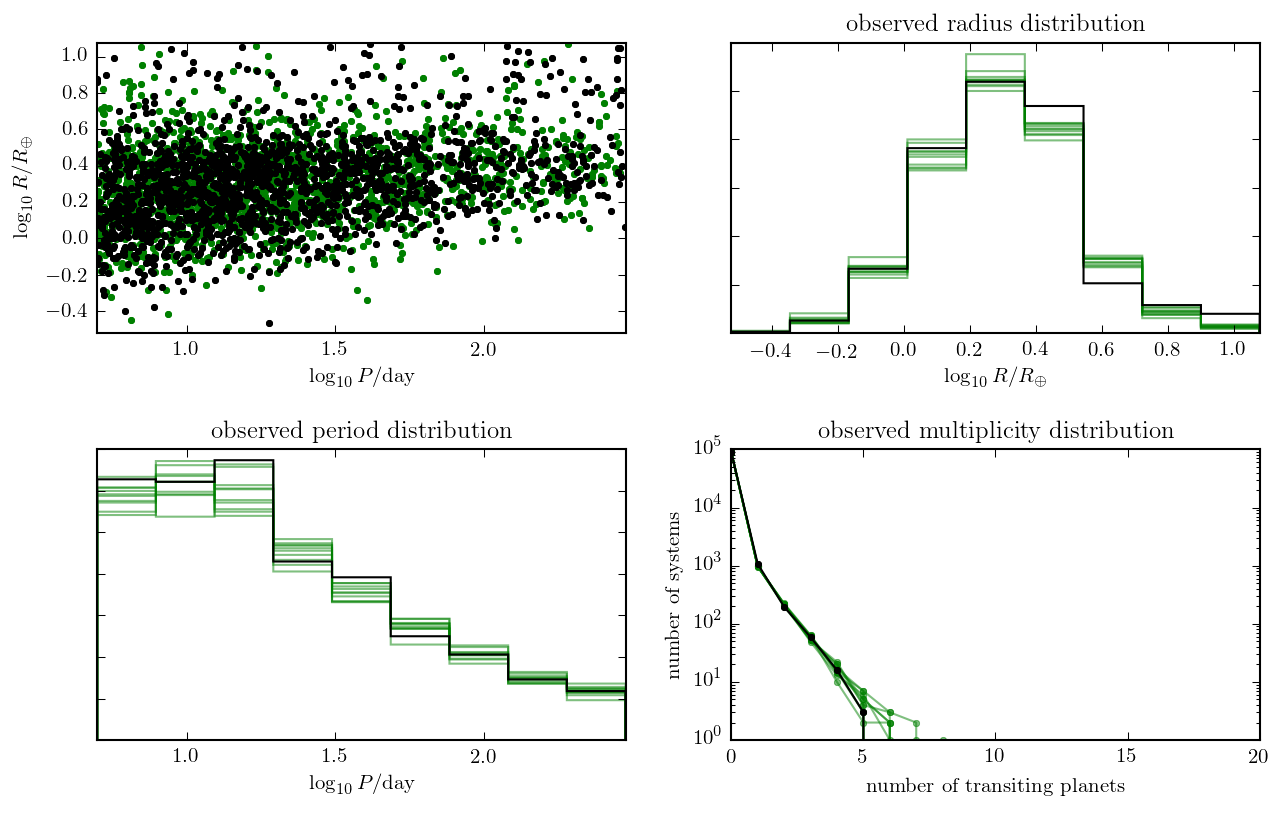

In [44]:
pars = np.array([
    -1.2,                 # multiplicity
    -2.0, -4, 3.0,        # radius
    0.1, -0.65, 13.0,     # period
    np.log(2e-2)          # inclination
])

plot_sim(sim, pars, kois=kois, multiplicity=multiplicity, nsamps=10)

In [22]:
def get_distance(theta):
    if not np.all(np.isfinite(theta)):
        return np.inf
    try:
        counts, _, catalog = sim.observe(get_param_vector(theta))
    except RuntimeError:
        return np.inf    
    if not len(catalog):
        return np.inf
    
    # Compare multiplicities.
    d1 = np.sum(np.abs(multiplicity - counts)) / np.max(multiplicity)
    
    # Compare periods and radii.
    d2 = ks_2samp(np.array(kois.koi_period), catalog[:, 0]).statistic
    d3 = ks_2samp(np.array(kois.koi_prad), catalog[:, 1]).statistic
    d = d1 + d2 + d3
    if not np.isfinite(d):
        return np.inf
    return d

def resample():
    sim.resample()

In [58]:
get_distance(np.append(0.0, [
    -2.0, -4, 3.0,        # radius
    0.0, -0.65, 15.0,     # period
    np.log(0.001)         # inclination
]))

0.073461177545673204

In [59]:
prior_mean = np.array([0.0, 0.0, 0.0, np.mean(RADIUS_RNG), 0.0, 0.0, np.mean(PERIOD_RNG), -3.0])
prior_std = np.array([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0])

def lnprior(theta):
    return -0.5 * np.sum(((theta - prior_mean) / prior_std)**2, axis=-1)

def from_prior(size=1):
    return prior_mean[None] + prior_std[None] * np.random.randn(size, len(prior_mean))

In [62]:
def abc(lnprior, from_prior, get_distance, resample, npop, eps, niter):    
    # First step. Sample from the prior:
    theta = from_prior(npop)
    ndim = theta.shape[1]
    resample()
    rho = np.array(list(map(get_distance, theta)))
    m = rho > eps
    while np.any(m):
        theta[m] = from_prior(np.sum(m))
        resample()
        rho[m] = list(map(get_distance, theta[m]))
        m = rho > eps
    
    # Initial weights:
    w = np.ones(len(theta)) / len(theta)
    tau2 = np.cov(theta, rowvar=0)

    # Iterate over thresholds:
    for _ in range(niter):
        eps = np.percentile(rho, 75)
        print(eps)
        
        m = np.ones(npop, dtype=bool)
        theta0 = np.array(theta)
        update = np.empty(npop)
        while np.any(m):
            inds = np.random.choice(np.arange(npop), size=m.sum(), p=w)
            c = np.random.multivariate_normal(np.zeros(len(tau2)), tau2, m.sum())
            theta[m] = theta0[inds] + c
            resample()
            rho[m] = np.array(list(map(get_distance, theta[m])))
            m = rho > eps

        # Update the weights:
        r = theta0.T[:, None, :] - theta.T[:, :, None]
        d = np.linalg.solve(tau2, r.reshape((ndim, -1))).reshape((ndim, npop, npop))
        w = np.sum(w[None, :] * np.exp(-0.5*np.sum(r * d, axis=0)), axis=-1)
        w = np.exp(lnprior(theta)) / w
        w /= np.sum(w)
        
        # And the covariance matrix:
        mu = np.sum(w[:, None] * theta, axis=0)
        norm = 1.0 / (1.0 - np.sum(w**2))
        r = theta - mu
        tau2 = np.sum(w[:, None, None] * r[:, :, None] * r[:, None, :], axis=0) * norm
        
    return theta, w

In [63]:
samps, weights = abc(lnprior, from_prior, get_distance, resample, 50, 20., 2)

1.85931605776
1.74890259118


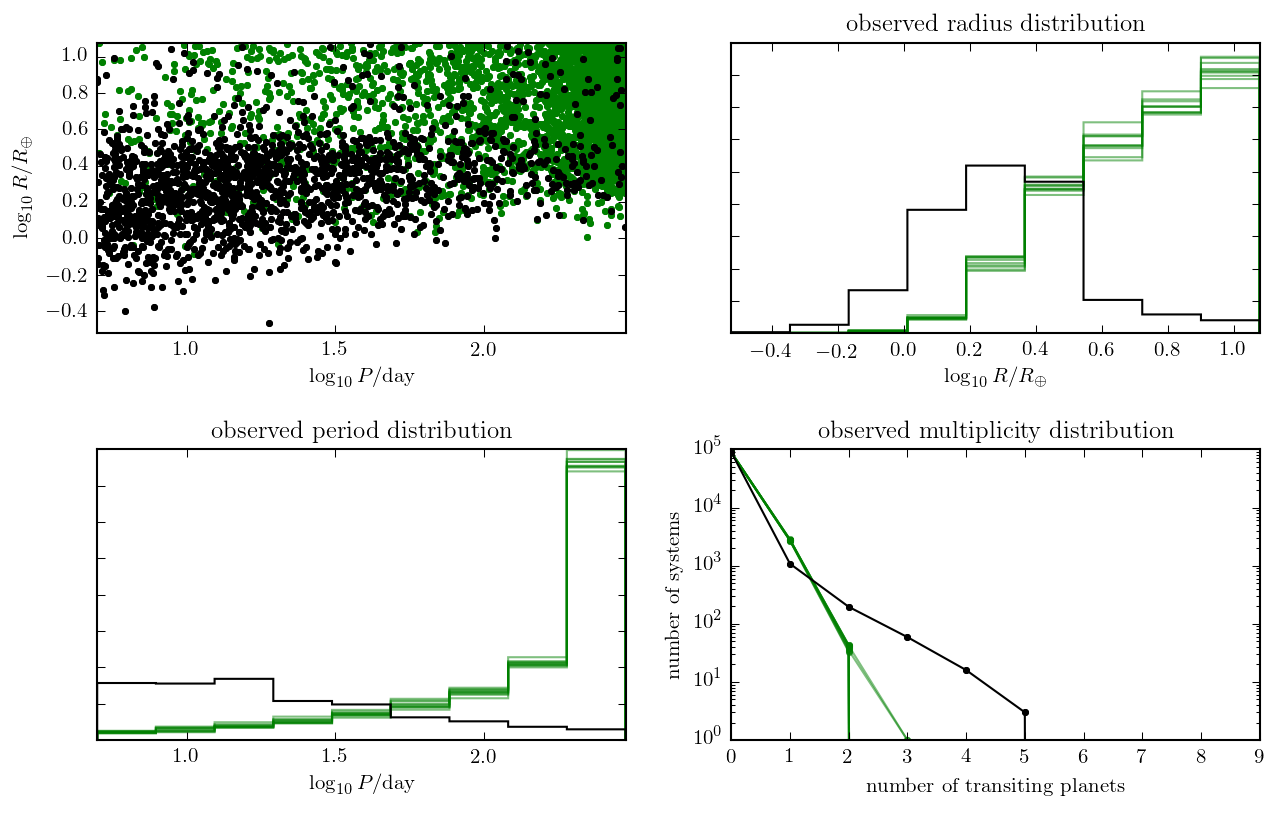

In [65]:
plot_sim(sim, samps[0], kois=kois, multiplicity=multiplicity, nsamps=10)